<a href="https://colab.research.google.com/github/susmita2000/Drug_repurposing/blob/main/Molecule_generation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

In [ ]:
use_cuda = torch.cuda.is_available()

In [ ]:
!git clone https://github.com/susmita2000/ReLeaSE.git
!pip install git+https://github.com/samoturk/mol2vec

Cloning into 'ReLeaSE'...
remote: Enumerating objects: 561, done.
remote: Total 561 (delta 0), reused 0 (delta 0), pack-reused 561
Receiving objects: 100% (561/561), 450.05 MiB | 35.98 MiB/s, done.
Resolving deltas: 100% (273/273), done.
Checking out files: 100% (31/31), done.
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-krf5_vsf
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-krf5_vsf
  Created wheel for mol2vec: filename=mol2vec-0.1-cp37-none-any.whl size=14028 sha256=642326f4ea49959b25af8c1da1a0776978b350d843dda365cbc745253a28a914
  Stored in directory: /tmp/pip-ephem-wheel-cache-l53x0r3i/wheels/96/0f/2d/a1092b9677c96453dc244b209544cac61bc8b974cbffb50063
Successfully built mol2vec


In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
!pip install keras-tqdm



add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
%cd ./ReLeaSE
%cd ./release
import numpy as np
from tqdm import tqdm, trange
import pickle
from rdkit import Chem, DataStructs
from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

/content/ReLeaSE
/content/ReLeaSE/release


In [ ]:
gen_data_path = '../data/chembl_22_clean_1576904_sorted_std_final.smi'

In [ ]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t', 
                         cols_to_read=[0], keep_header=True, tokens=tokens)

In [ ]:

def plot_hist(prediction, n_to_generate):
    print("Mean value of predictions:", prediction.mean())
    print("Proportion of valid SMILES:", len(prediction)/n_to_generate)
    ax = sns.kdeplot(prediction, shade=True)
    ax.set(xlabel='Predicted vina', 
           title='Distribution of predicted vina for generated molecules')
    plt.show()
def estimate_and_update(generator, predictor, n_to_generate, **kwargs):
    generated = []
    pbar = tqdm(range(n_to_generate))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.append(generator.evaluate(gen_data, predict_len=120)[1:-1])

    sanitized = canonical_smiles(generated, sanitize=False, throw_warning=False)[:-1]
    unique_smiles = list(np.unique(sanitized))[1:]
    smiles, prediction, nan_smiles = predictor.predict(unique_smiles, get_features=get_fp)  
                                                       
    plot_hist(prediction, n_to_generate)
        
    return smiles, prediction



In [ ]:
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)
model_path = '../checkpoints/generator/checkpoint_biggest_rnn'

my_generator.load_model(model_path)
!pip install mordred
from data import PredictorData
from utils import get_desc, get_fp
from mordred import Calculator, descriptors
calc = Calculator(descriptors, ignore_3D=True)

     |████████████████████████████████| 133kB 4.9MB/s 
  Created wheel for mordred: filename=mordred-1.2.0-cp37-none-any.whl size=176721 sha256=bbf6dc2499e694236b82340eb57c9e5c35312c35195e488ca4783142ab93d349
  Stored in directory: /root/.cache/pip/wheels/ac/74/3f/2fd81b1187013f2eadb15620434813f1824c4c03b7bd1f94f6
Successfully built mordred


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
pred_data = PredictorData(path='../data/supercompcut.csv', get_features=get_fp)

Mounted at /content/drive


In [ ]:
from predictor import VanillaQSAR
from sklearn.ensemble import RandomForestRegressor as RFR

model_instance = RFR
model_params = {'n_estimators': 500, 'n_jobs': 20}
my_predictor = VanillaQSAR(model_instance=model_instance,
                           model_params=model_params,
                           model_type='regressor')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
my_predictor.fit_model(pred_data, cv_split='random')

([0.7885748589947374,
  0.8054514167510706,
  0.8031973984015557,
  0.7762516152602682,
  0.799439437816687],
 'R^2 score')

In [ ]:

def get_reward_min(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(-2*prop[0]/3 + 3)

In [ ]:
from reinforcement import Reinforcement

my_generator_min = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=hidden_size,
                                 output_size=gen_data.n_characters, layer_type=layer_type,
                                 n_layers=1, is_bidirectional=False, has_stack=True,
                                 stack_width=stack_width, stack_depth=stack_depth, 
                                 use_cuda=use_cuda, 
                                 optimizer_instance=optimizer_instance, lr=lr)
my_generator_min.load_model(model_path)

RL_min = Reinforcement(my_generator_min, my_predictor, get_reward_min)

n_to_generate = 200
n_policy_replay = 10
n_policy = 15
n_iterations = 50

def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

def get_reward_min(smiles, predictor, invalid_reward=0.0, get_features=get_fp):
    mol, prop, nan_smiles = predictor.predict([smiles], get_features=get_features)
    if len(nan_smiles) == 1:
        return invalid_reward
    return np.exp(-2*prop[0]/3 + 3)

Generating molecules...:   0%|          | 0/10000 [00:00<?, ?it/s]/content/ReLeaSE/release/data.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor).cuda()
Generating molecules...: 100%|██████████| 10000/10000 [11:28<00:00, 14.52it/s]


Mean value of predictions: -6.857583789853405
Proportion of valid SMILES: 0.6321


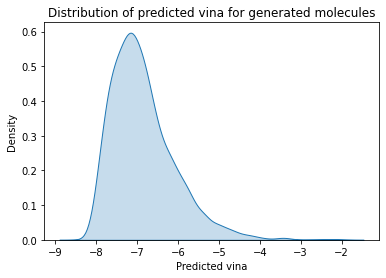

In [ ]:
smiles_biased_min, prediction_biased_min = estimate_and_update(RL_min.generator, 
                                                           my_predictor,
                                                           n_to_generate=10000)



In [17]:
print(len(smiles_biased_min))
from numpy import save
save('/content/ReLeaSE/output2', smiles_biased_min)

6321
